# **Denoising Diffusion Probabilstic Model (DDPM)**

## **Import Dependencies**

In [1]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.optim import AdamW
from diffusers import UNet2DModel, DDPMScheduler, DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from accelerate import accelerator, Accelerator
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random
import timeit

## **Define Configs**

In [2]:
RANDOM_SEED = 42
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS = 50
NUM_GENERATE_IMAGES = 9
NUM_TIMESTEPS = 1000
MIXED_PRECISION = 'fp16'
GRADIENT_ACCUMULATION_STEPS = 1

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## **Load Datasets**

In [3]:
# Load the dataset from Hugging Face
dataset = load_dataset('huggan/smithsonian_butterflies_subset', split='train')

Repo card metadata block was not found. Setting CardData to empty.


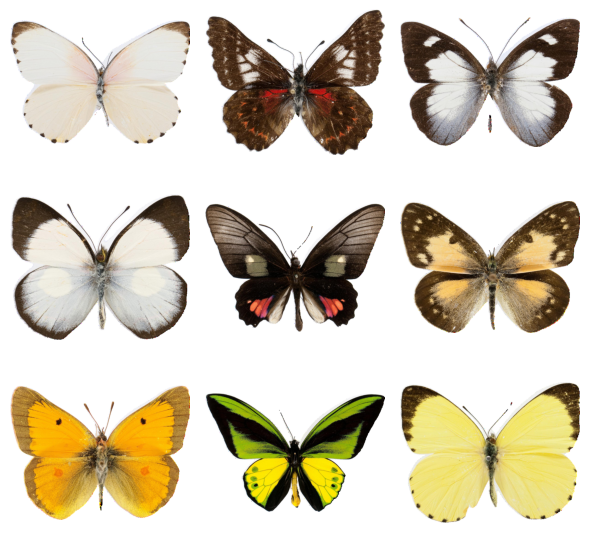

In [4]:
# Plot the data
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(6, 6))
axes = axes.flatten()

for ax in axes:
    random_id = random.randint(0, len(dataset))
    ax.imshow(dataset[random_id]['image'])
    ax.axis('off')

plt.tight_layout()
plt.show()

## **Data Augmentation**

In [5]:
# Define all the transforms
preprocess = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]
)

# Tranform the images in the dataset
def transform(examples):
    images = [preprocess(image.convert('RGB')) for image in examples['image']]
    return {'images': images}

dataset.set_transform(transform)

## **DataLoader**

In [6]:
# Define the train dataloader
train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

## **Model**

In [7]:
# Define the model and send it to GPU
model = UNet2DModel(
    sample_size=IMG_SIZE,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'DownBlock2D',
        'AttnDownBlock2D',
        'DownBlock2D'
    ),
    up_block_types=(
        'UpBlock2D',
        'AttnUpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D',
        'UpBlock2D'
    )
)

model = model.to(device)

In [8]:
# Check if the input and output image shapes are same
sample_image = dataset[0]['images'].unsqueeze(0).to(device)
print('Input shape', sample_image.shape)
print('Output shape', model(sample_image, timestep=0).sample.shape)

Input shape torch.Size([1, 3, 128, 128])
Output shape torch.Size([1, 3, 128, 128])


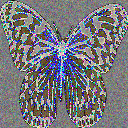

In [9]:
# Noise scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=NUM_TIMESTEPS)
noise = torch.randn(sample_image.shape).to(device)
timesteps = torch.LongTensor([50]).to(device)
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray((
    (noisy_image.permute(0, 2, 3, 1) * 127.5)
    .type(torch.uint8)
    .cpu()
    .numpy()[0]
))

In [10]:
noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
print(loss)

tensor(1.1955, device='cuda:0', grad_fn=<MseLossBackward0>)


In [11]:
# Function to generate sample images
def sample_image_generation(model, noise_scheduler, num_generate_images, random_seed, num_timesteps):
    pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

    images = pipeline(
        batch_size=num_generate_images,
        generator=torch.manual_seed(random_seed),
        num_inference_steps=num_timesteps
    ).images

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        ax.imshow(images[i])

    plt.tight_layout()
    plt.imshow()

In [12]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

# Define the learning rate scheduler
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(train_dataloader) * 50
)

# Initialize HuggingFace Accelerator correctly
accelerator = Accelerator(
    mixed_precision=MIXED_PRECISION,
    gradient_accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

# Prepare model, optimizer, dataloader, and scheduler for training
model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)

## **Training**

In [ ]:
# Training process
start = timeit.default_timer()
for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    model.train()
    train_running_loss = 0
    for idx, batch in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        clean_images = batch['images'].to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)

        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size, )).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        train_running_loss += loss.item()

    train_loss = train_running_loss / (idx + 1)
    train_learning_rate = lr_scheduler.get_last_lr()[0]

    print('-'*30)
    print(f'Train Loss EPOCH {epoch+1}: {train_loss:.4f}')
    print(f'Train Learning Rate EPOCH {epoch+1}: {train_learning_rate}')
    
    if epoch % 10 == 0:
        sample_image_generation(model, noise_scheduler, NUM_GENERATE_IMAGES, RANDOM_SEED, NUM_TIMESTEPS)
    print('-'*30)

stop = timeit.default_timer()
print(f'Training Time: {stop - start:.2f}s')
